In [1]:
from datetime import datetime
import json
from collections import Counter

import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
import torchmetrics

from deeprec.torch.trainer import Trainer, set_device
from deeprec import ROOT

In [2]:
with open('../data/metadata.json', 'r') as fp:
    meta = json.load(fp)

meta.keys()

dict_keys(['title_emb_size', 'string_na', 'genres', 'ages', 'occupations', 'user', 'movie', 'city', 'state'])

In [26]:
class Vocab(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, x):
        c = Counter(x)
        self.lookup_ = {
            str(v).lower(): k for k, v in enumerate([x[0] for x in sorted(c.items(), key=lambda x: x[1], reverse=True)])
        }

    def transform(self, x):
        return [self.lookup_.get(str(xx).lower(), len(self.lookup_)+1) for xx in x]

In [27]:
df = pd.read_parquet('../data/train.parq.gzip').drop('rating', axis=1)
df.head()

,user,movie,hour,day_of_week,month,ts,gender,age,occupation,city,...,embed_15,embed_16,embed_17,embed_18,embed_19,embed_20,embed_21,embed_22,embed_23,embed_24
index,,,,,,,,,,,,,,,,,,,,,
693094,1489,2648,3,5,11,2000-11-25 03:35:14,1,35,2,Evanston,...,0.059832,0.46583,0.774960,0.43321,0.370830,0.140020,0.521110,-0.960430,-0.622770,0.245130
563664,2440,3101,17,1,11,2000-11-14 17:03:49,0,50,17,Ashburnham,...,1.982520,0.84989,1.708770,1.34452,-1.051670,-0.032240,0.662540,-0.448420,-1.197040,-0.698660
192,682,1193,16,3,11,2000-11-30 16:33:10,0,25,4,Carrboro,...,2.176160,2.86298,2.238394,-2.15952,1.210480,-3.436165,-0.329595,3.619880,-2.470530,1.399963
664671,3512,1005,17,0,8,2000-08-28 17:16:19,0,18,17,Cambridge,...,-1.662040,0.99335,-1.184181,1.58626,0.718946,-1.731300,2.357530,1.096584,-2.896070,0.150750
967203,5074,1202,5,5,7,2000-07-01 05:14:36,0,1,0,Purcellville,...,1.998510,1.07155,-0.863230,0.24211,-0.773756,0.235041,1.170840,-2.078201,-1.310696,-0.964250


In [28]:
state_enc = Vocab()
state_enc.fit(df['state'])

user_enc = Vocab()
user_enc.fit(df['user'])

movie_enc = Vocab()
movie_enc.fit(df['movie'])

In [29]:
df = pd.read_parquet('../data/train.parq.gzip', columns=['rating'])
df.head()

,rating
index,
693094,3
563664,4
192,5
664671,3
967203,5


In [30]:
set(df['rating'])

{1, 2, 3, 4, 5}

In [35]:
class MovieDataset(Dataset):
    def __init__(self, filename, vocabs):
        drop_cols = ['rating', 'city', 'hour', 'day_of_week', 'month', 'ts']
        x = pd.read_parquet(filename).drop(drop_cols, axis=1)
        y = pd.read_parquet(filename, columns=['rating'])

        x['state'] = vocabs['state'].transform(x['state'])
        x['user'] = vocabs['user'].transform(x['user'])
        x['movie'] = vocabs['movie'].transform(x['movie'])

        self.feature_names = x.columns
        self.x = x.to_dict('records')
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [36]:
encoders = {
    'user': user_enc,
    'movie': movie_enc,
    'state': state_enc
}

train = MovieDataset('../data/train.parq.gzip', vocabs=encoders)
test = MovieDataset('../data/test.parq.gzip', vocabs=encoders)

In [37]:
print(len(train.feature_names))
train.feature_names

50


Index(['user', 'movie', 'gender', 'age', 'occupation', 'state', 'year',
       'genre_action', 'genre_adventure', 'genre_animation', 'genre_childrens',
       'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
       'genre_fantasy', 'genre_filmnoir', 'genre_horror', 'genre_musical',
       'genre_mystery', 'genre_romance', 'genre_scifi', 'genre_thriller',
       'genre_war', 'genre_western', 'embed_0', 'embed_1', 'embed_2',
       'embed_3', 'embed_4', 'embed_5', 'embed_6', 'embed_7', 'embed_8',
       'embed_9', 'embed_10', 'embed_11', 'embed_12', 'embed_13', 'embed_14',
       'embed_15', 'embed_16', 'embed_17', 'embed_18', 'embed_19', 'embed_20',
       'embed_21', 'embed_22', 'embed_23', 'embed_24'],
      dtype='object')

In [38]:
dl = DataLoader(train, 4)
next(iter(dl))

[{'user': tensor([ 406, 5675, 3393,  579]),
  'movie': tensor([ 779,  309,   42, 1741]),
  'gender': tensor([1, 0, 0, 0]),
  'age': tensor([35, 50, 25, 18]),
  'occupation': tensor([ 2, 17,  4, 17]),
  'state': tensor([ 3,  5, 18,  5]),
  'year': tensor([1931, 1987, 1975, 1996]),
  'genre_action': tensor([0, 0, 0, 0]),
  'genre_adventure': tensor([0, 0, 0, 0]),
  'genre_animation': tensor([0, 0, 0, 0]),
  'genre_childrens': tensor([0, 0, 0, 1]),
  'genre_comedy': tensor([0, 0, 0, 1]),
  'genre_crime': tensor([0, 0, 0, 0]),
  'genre_documentary': tensor([0, 0, 0, 0]),
  'genre_drama': tensor([0, 0, 1, 0]),
  'genre_fantasy': tensor([0, 0, 0, 0]),
  'genre_filmnoir': tensor([0, 0, 0, 0]),
  'genre_horror': tensor([1, 0, 0, 0]),
  'genre_musical': tensor([0, 0, 0, 0]),
  'genre_mystery': tensor([0, 0, 0, 0]),
  'genre_romance': tensor([0, 0, 0, 0]),
  'genre_scifi': tensor([0, 0, 0, 0]),
  'genre_thriller': tensor([0, 1, 0, 0]),
  'genre_war': tensor([0, 0, 0, 0]),
  'genre_western': tens

In [39]:
z = next(iter(dl))

In [40]:
def stack_features(inputs, feat):
    return torch.stack([v for k, v in inputs.items() if feat in k], 1)


stack_features(z[0], 'genre')

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [41]:
class RecModel(nn.Module):
    def __init__(self, metadata, n_features=54):
        super().__init__()
        self.meta = metadata
        self.embed_dims = {
            'large': 25,
            'med': 7,
            'small': 3
        }
        self.loss_func = nn.MSELoss()

        self.user_embeds = nn.Embedding(
            num_embeddings=len(user_enc.lookup_.keys()) + 2,
            embedding_dim=self.embed_dims['med']
        )

        self.movie_embeds = nn.Embedding(
            num_embeddings=len(movie_enc.lookup_.keys()) + 2,
            embedding_dim=self.embed_dims['med']
        )

        self.user_model = nn.Sequential(
            nn.LazyLinear(out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU()
        )

        self.movie_model = nn.Sequential(
            nn.LazyLinear(out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=32),
            nn.ReLU()
        )

        self.model = nn.Sequential(
            nn.LazyLinear(out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=1)
        )

    def forward(self, x):
        x_user = torch.concat(
            (
                self.user_embeds(x['user']),
                x['state'].unsqueeze(-1),
                x['age'].unsqueeze(-1),
                x['occupation'].unsqueeze(-1),
                x['gender'].unsqueeze(-1),
            ),
            dim=1
        )

        x_movie = torch.concat(
            (
                self.movie_embeds(x['movie']),
                stack_features(x, 'genre'),
                x['year'].unsqueeze(-1)
            ),
            dim=1
        )
        user_block = self.user_model(x_user)
        movie_block = self.movie_model(x_movie.float())
        x = self.model(torch.concat((user_block, movie_block), dim=1))
        return x

    def predict(self, x):
        return self(x)

In [42]:
NOW = datetime.now().strftime('%Y%m%d-%H%M')
LOG_DIR = ROOT.joinpath('runs', NOW)
BATCH = 10_000

train_loader = DataLoader(train, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH)

device = set_device()
mod = RecModel(metadata=meta)
opt = torch.optim.AdamW(mod.parameters(), lr=0.01)
trainer = Trainer(
    mod, epochs=10, device=device, log_dir=LOG_DIR, checkpoint_file=LOG_DIR.joinpath('model.pt'),
    optimizer=opt, score_funcs={'mse': torchmetrics.MeanSquaredError()}
)
trainer.fit(train_loader, test_loader, verbose=True)

/Users/christophersantiago/miniforge3/envs/deeprec/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
Batch:  99%|█████████▉| 90/91 [00:35<00:00,  2.78it/s]
                                                      
Epoch:  10%|█         | 1/10 [00:37<05:38, 37.62s/it] 

defaultdict(<class 'list'>, {'epoch': [0], 'train_loss': [3.8346491292282776], 'train_mse': [2.614243268966675], 'valid_loss': [1.2551360130310059], 'valid_mse': [1.2491421699523926]})



Batch:  99%|█████████▉| 90/91 [00:34<00:00,  2.81it/s]
                                                      
Epoch:  20%|██        | 2/10 [01:14<04:56, 37.11s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1], 'train_loss': [3.8346491292282776, 1.1760320355603984], 'train_mse': [2.614243268966675, 1.1750552654266357], 'valid_loss': [1.2551360130310059, 1.0789755366065286], 'valid_mse': [1.2491421699523926, 1.0727108716964722]})



Batch:  99%|█████████▉| 90/91 [00:35<00:00,  2.75it/s]
                                                      
Epoch:  30%|███       | 3/10 [01:52<04:23, 37.60s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2], 'train_loss': [3.8346491292282776, 1.1760320355603984, 0.917761410330678], 'train_mse': [2.614243268966675, 1.1750552654266357, 0.9131425619125366], 'valid_loss': [1.2551360130310059, 1.0789755366065286, 0.885902610692111], 'valid_mse': [1.2491421699523926, 1.0727108716964722, 0.847935676574707]})



Batch:  99%|█████████▉| 90/91 [00:34<00:00,  2.33it/s]
                                                      
Epoch:  40%|████      | 4/10 [02:29<03:43, 37.18s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3], 'train_loss': [3.8346491292282776, 1.1760320355603984, 0.917761410330678, 0.8801310874603607], 'train_mse': [2.614243268966675, 1.1750552654266357, 0.9131425619125366, 0.8789875507354736], 'valid_loss': [1.2551360130310059, 1.0789755366065286, 0.885902610692111, 0.8618097467855974], 'valid_mse': [1.2491421699523926, 1.0727108716964722, 0.847935676574707, 0.8285960555076599]})



Batch:  99%|█████████▉| 90/91 [00:33<00:00,  2.93it/s]
                                                      
Epoch:  50%|█████     | 5/10 [03:04<03:03, 36.64s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4], 'train_loss': [3.8346491292282776, 1.1760320355603984, 0.917761410330678, 0.8801310874603607, 0.8165235008512225], 'train_mse': [2.614243268966675, 1.1750552654266357, 0.9131425619125366, 0.8789875507354736, 0.8142904043197632], 'valid_loss': [1.2551360130310059, 1.0789755366065286, 0.885902610692111, 0.8618097467855974, 0.8629499890587546], 'valid_mse': [1.2491421699523926, 1.0727108716964722, 0.847935676574707, 0.8285960555076599, 0.8258060216903687]})



Batch:  99%|█████████▉| 90/91 [00:33<00:00,  3.27it/s]
                                                      
Epoch:  60%|██████    | 6/10 [03:42<02:27, 36.88s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5], 'train_loss': [3.8346491292282776, 1.1760320355603984, 0.917761410330678, 0.8801310874603607, 0.8165235008512225, 0.8137209218936962], 'train_mse': [2.614243268966675, 1.1750552654266357, 0.9131425619125366, 0.8789875507354736, 0.8142904043197632, 0.8104991912841797], 'valid_loss': [1.2551360130310059, 1.0789755366065286, 0.885902610692111, 0.8618097467855974, 0.8629499890587546, 0.8564023754813455], 'valid_mse': [1.2491421699523926, 1.0727108716964722, 0.847935676574707, 0.8285960555076599, 0.8258060216903687, 0.8226078152656555]})



Batch:  99%|█████████▉| 90/91 [00:34<00:00,  2.33it/s]
                                                      
Epoch:  70%|███████   | 7/10 [04:18<01:49, 36.57s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6], 'train_loss': [3.8346491292282776, 1.1760320355603984, 0.917761410330678, 0.8801310874603607, 0.8165235008512225, 0.8137209218936962, 0.8104931260203267], 'train_mse': [2.614243268966675, 1.1750552654266357, 0.9131425619125366, 0.8789875507354736, 0.8142904043197632, 0.8104991912841797, 0.808694064617157], 'valid_loss': [1.2551360130310059, 1.0789755366065286, 0.885902610692111, 0.8618097467855974, 0.8629499890587546, 0.8564023754813455, 0.8680156577717174], 'valid_mse': [1.2491421699523926, 1.0727108716964722, 0.847935676574707, 0.8285960555076599, 0.8258060216903687, 0.8226078152656555, 0.8281806111335754]})



Batch:  99%|█████████▉| 90/91 [00:33<00:00,  3.11it/s]
                                                      
Epoch:  80%|████████  | 8/10 [04:53<01:12, 36.28s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7], 'train_loss': [3.8346491292282776, 1.1760320355603984, 0.917761410330678, 0.8801310874603607, 0.8165235008512225, 0.8137209218936962, 0.8104931260203267, 0.8090255489716163], 'train_mse': [2.614243268966675, 1.1750552654266357, 0.9131425619125366, 0.8789875507354736, 0.8142904043197632, 0.8104991912841797, 0.808694064617157, 0.807915449142456], 'valid_loss': [1.2551360130310059, 1.0789755366065286, 0.885902610692111, 0.8618097467855974, 0.8629499890587546, 0.8564023754813455, 0.8680156577717174, 0.8590629209171642], 'valid_mse': [1.2491421699523926, 1.0727108716964722, 0.847935676574707, 0.8285960555076599, 0.8258060216903687, 0.8226078152656555, 0.8281806111335754, 0.821287989616394]})



Batch:  99%|█████████▉| 90/91 [00:34<00:00,  3.13it/s]
                                                      
Epoch:  90%|█████████ | 9/10 [05:30<00:36, 36.58s/it] 

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'train_loss': [3.8346491292282776, 1.1760320355603984, 0.917761410330678, 0.8801310874603607, 0.8165235008512225, 0.8137209218936962, 0.8104931260203267, 0.8090255489716163, 0.8082333108881018], 'train_mse': [2.614243268966675, 1.1750552654266357, 0.9131425619125366, 0.8789875507354736, 0.8142904043197632, 0.8104991912841797, 0.808694064617157, 0.807915449142456, 0.8065866231918335], 'valid_loss': [1.2551360130310059, 1.0789755366065286, 0.885902610692111, 0.8618097467855974, 0.8629499890587546, 0.8564023754813455, 0.8680156577717174, 0.8590629209171642, 0.8617471348155629], 'valid_mse': [1.2491421699523926, 1.0727108716964722, 0.847935676574707, 0.8285960555076599, 0.8258060216903687, 0.8226078152656555, 0.8281806111335754, 0.821287989616394, 0.8246778845787048]})



Batch:  99%|█████████▉| 90/91 [00:34<00:00,  1.56it/s]
                                                      
Epoch: 100%|██████████| 10/10 [06:06<00:00, 36.69s/it]

defaultdict(<class 'list'>, {'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'train_loss': [3.8346491292282776, 1.1760320355603984, 0.917761410330678, 0.8801310874603607, 0.8165235008512225, 0.8137209218936962, 0.8104931260203267, 0.8090255489716163, 0.8082333108881018, 0.8065230872604873], 'train_mse': [2.614243268966675, 1.1750552654266357, 0.9131425619125366, 0.8789875507354736, 0.8142904043197632, 0.8104991912841797, 0.808694064617157, 0.807915449142456, 0.8065866231918335, 0.8061040043830872], 'valid_loss': [1.2551360130310059, 1.0789755366065286, 0.885902610692111, 0.8618097467855974, 0.8629499890587546, 0.8564023754813455, 0.8680156577717174, 0.8590629209171642, 0.8617471348155629, 0.8566252968528054], 'valid_mse': [1.2491421699523926, 1.0727108716964722, 0.847935676574707, 0.8285960555076599, 0.8258060216903687, 0.8226078152656555, 0.8281806111335754, 0.821287989616394, 0.8246778845787048, 0.8253962993621826]})


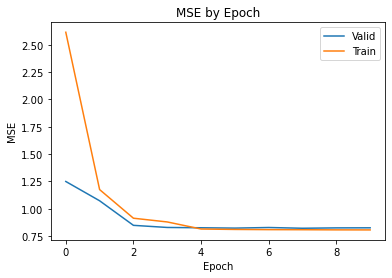

In [43]:
import matplotlib.pyplot as plt

plt.plot(trainer.results['valid_mse'], label='Valid')
plt.plot(trainer.results['train_mse'], label='Train')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE by Epoch')
plt.show()

In [44]:
{e:v for e,v in enumerate(torch.sqrt(torch.tensor(trainer.results['valid_mse'])))}

{0: tensor(1.1177),
 1: tensor(1.0357),
 2: tensor(0.9208),
 3: tensor(0.9103),
 4: tensor(0.9087),
 5: tensor(0.9070),
 6: tensor(0.9100),
 7: tensor(0.9062),
 8: tensor(0.9081),
 9: tensor(0.9085)}

<hr>

# DEBUGGING

In [62]:
dl = DataLoader(train, 32)
z = next(iter(dl))
z

[{'user': tensor([  66, 1566, 1665,   60,   30, 2355, 1692,   64,  934, 1067, 1065, 2515,
           566, 1637,  862,  129,  219, 1960,   17,   28,  441,  327,   53,  431,
            27,  812, 2028,  803,  137, 2515, 1158,  682]),
  'movie': tensor([3132, 3132, 3132, 3132, 3132, 2821, 3132, 3132, 3132, 3132, 3132, 3132,
          3132, 3132, 3132, 3132, 3132, 3132, 3132, 2823, 3132, 3132, 3132, 3132,
          3132, 3132, 3132, 3132, 3132, 3132, 3132, 2823]),
  'hour': tensor([ 1,  3, 17, 20,  6, 21,  6,  7, 23, 23, 12, 21, 21, 21,  0,  0,  2, 14,
          15, 18,  4, 13, 16, 16, 17,  8, 21,  2,  3,  4,  6,  8]),
  'day_of_week': tensor([2, 2, 5, 2, 6, 2, 0, 5, 3, 3, 2, 5, 4, 5, 4, 5, 0, 3, 3, 0, 6, 3, 0, 1,
          5, 1, 2, 4, 1, 0, 2, 2]),
  'month': tensor([ 4,  4,  4,  4,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,  8,  8,
           8,  8,  9,  9,  9,  9,  9, 10, 10, 11, 11, 11, 11, 11]),
  'gender': tensor([1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,

In [86]:
user_embeds = nn.Embedding(
    num_embeddings=max(meta['occupations'])+1,
    embedding_dim=25
)

In [93]:
user_embeds(z[0]['occupation']).shape

torch.Size([32, 25])

In [120]:
z[0]['gender'].dtype

torch.int64

In [121]:
stack_features(z[0], 'genre').float()

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0.,

In [122]:
meta['movie']

{'2858': 0.003427283697707179,
 '260': 0.002990375011622571,
 '1196': 0.002989375220578899,
 '1210': 0.0028823975789060087,
 '480': 0.0026714416686912435,
 '2028': 0.002652445638861478,
 '589': 0.0026484464746867904,
 '2571': 0.0025894588031101498,
 '1270': 0.002582460265804447,
 '593': 0.0025774613105860873,
 '1580': 0.0025374696688392124,
 '1198': 0.0025134746837910875,
 '608': 0.0025124748927474157,
 '2762': 0.002458486176389135,
 '110': 0.002442489519690385,
 '2396': 0.002368504982458666,
 '1197': 0.0023175156392314005,
 '527': 0.0023035185646199945,
 '1617': 0.0022875219079212445,
 '1265': 0.0022775239974845256,
 '1097': 0.002268525878091479,
 '2628': 0.002249529848261713,
 '2997': 0.0022405317288686664,
 '318': 0.0022265346542572604,
 '858': 0.002222535490082573,
 '356': 0.0021935415498160883,
 '2716': 0.002180544266248354,
 '296': 0.0021705463558116356,
 '1240': 0.0020975616096235885,
 '1': 0.0020765659977064793,
 '1214': 0.00202357707239187,
 '2916': 0.0019955829231690578,
 '45